[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/intel-analytics/BigDL/blob/main/python/orca/colab-notebook/quickstart/pytorch_distributed_lenet_mnist.ipynb)

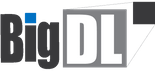
---

##### Copyright 2016 The BigDL Authors.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

## **Environment Preparation**

**Install Java 8**

Run the cell on the **Google Colab** to install jdk 1.8.

**Note:** if you run this notebook on your computer, root permission is required when running the cell to install Java 8. (You may ignore this cell if Java 8 has already been set up in your computer).

In [1]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_312"
OpenJDK Runtime Environment (build 1.8.0_312-8u312-b07-0ubuntu1~18.04-b07)
OpenJDK 64-Bit Server VM (build 25.312-b07, mixed mode)


**Install BigDL Orca**

 

You can install the latest pre-release version using `pip install --pre --upgrade bigdl-orca[ray]`.

In [2]:
# Installing BigDL Orca from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade bigdl-orca[ray]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.9 MB 1.5 MB/s 
     |████████████████████████████████| 71.0 MB 350 bytes/s 
     |████████████████████████████████| 35.4 MB 479 kB/s 
     |████████████████████████████████| 51.6 MB 1.6 kB/s 
     |████████████████████████████████| 85 kB 4.7 MB/s 
     |████████████████████████████████| 65 kB 4.2 MB/s 
     |████████████████████████████████| 1.1 MB 43.6 MB/s 
     |████████████████████████████████| 57.6 MB 1.1 MB/s 
     |████████████████████████████████| 144 kB 50.7 MB/s 
     |████████████████████████████████| 271 kB 60.0 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
     |████████████████████████████████| 218.4 MB 46 kB/s 
     |████████████████████████████████| 51.0 MB 35 kB/s 
     |████████████████████████████████| 197 kB 58.5 MB/s 
     |████████████████████████████████| 246 kB 58.4 MB/s 
     |█████████████████████████████

In [3]:
# Install python dependencies
!pip install torch torchvision torchmetrics
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 10.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Distributed PyTorch using Orca APIs**

In this guide we will describe how to scale out PyTorch programs using `ray` package on Orca in 4 simple steps.

In [4]:
# import necesary libraries and modules
from __future__ import print_function
import os
import argparse

from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca import OrcaContext

### **Step 1: Init Orca Context**

In [5]:
# recommended to set it to True when running BigDL in Jupyter notebook. 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

cluster_mode = "local"

if cluster_mode == "local":
    init_orca_context(cores=1, memory="2g") # run in local mode
elif cluster_mode == "k8s":
    init_orca_context(cluster_mode="k8s", num_nodes=2, cores=4) # run on K8s cluster
elif cluster_mode == "yarn":
    init_orca_context(
      cluster_mode="yarn-client", cores=4, num_nodes=2, memory="2g",
      driver_memory="10g", driver_cores=1) # run on Hadoop YARN cluster

Initializing orca context
Current pyspark location is : /usr/local/lib/python3.7/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/dist-packages/bigdl/share/core/lib/all-2.1.0-20220314.094552-2.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_2.4.6-2.1.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/orca/lib/bigdl-orca-spark_2.4.6-2.1.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
Successfully got a SparkContext


### **Step 2: Define the Model**
You may define your model, loss and optimizer in the same way as in any standard (single node) PyTorch program.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

criterion = nn.NLLLoss()

After defining your model, you need to define a *Model Creator Function* that returns an instance of your model, and a *Optimizer Creator Function* that returns a PyTorch optimizer.

In [7]:
def model_creator(config):
    model = LeNet()
    return model

def optim_creator(model, config):
    return torch.optim.Adam(model.parameters(), lr=0.001)

### **Step 3: Define Train Dataset**

You can define the dataset using a *Data Creator Function* that has two parameters `config` and `batch_size` and returns a PyTorch `DataLoader`.

In [8]:
import torch
from torchvision import datasets, transforms

torch.manual_seed(0)
batch_size = 320
test_batch_size = 320
dir = '/tmp/dataset'

def train_loader_creator(config, batch_size):
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(dir, train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
    return train_loader

def test_loader_creator(config, batch_size):
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(dir, train=False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=False)
    return test_loader

### **Step 4: Fit with Orca Estimator**

First, Create an Estimator and set its backend to `ray`.

In [9]:
from bigdl.orca.learn.pytorch import Estimator
from bigdl.orca.learn.metrics import Accuracy

est = Estimator.from_torch(model=model_creator, optimizer=optim_creator, loss=criterion, metrics=[Accuracy()],
                           backend="ray", use_tqdm=True)

2022-07-25 15:07:55,051	INFO services.py:1340 -- View the Ray dashboard at http://172.28.0.2:8265


{'node_ip_address': '172.28.0.2', 'raylet_ip_address': '172.28.0.2', 'redis_address': '172.28.0.2:6379', 'object_store_address': '/tmp/ray/session_2022-07-25_15-07-51_193963_60/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-07-25_15-07-51_193963_60/sockets/raylet', 'webui_url': '172.28.0.2:8265', 'session_dir': '/tmp/ray/session_2022-07-25_15-07-51_193963_60', 'metrics_export_port': 57319, 'node_id': '65cde16661b6d2903609c50c1f2fbc0448b964081a08d60b8ae8ed05'}


(PytorchRayWorker pid=552) [2022-07-25 15:07:59] INFO     Added key: store_based_barrier_key:1 to store for rank: 0
(PytorchRayWorker pid=552) [2022-07-25 15:07:59] INFO     Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 1 nodes.


Next, fit and evaluate using the Estimator.

In [10]:
from bigdl.orca.learn.trigger import EveryEpoch 

est.fit(data=train_loader_creator, epochs=1, batch_size=batch_size)

(PytorchRayWorker pid=552) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
(PytorchRayWorker pid=552) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to /tmp/dataset/MNIST/raw/train-images-idx3-ubyte.gz


100%|██████████| 9912422/9912422 [00:00<00:00, 47389826.94it/s]


(PytorchRayWorker pid=552) Extracting /tmp/dataset/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/dataset/MNIST/raw
(PytorchRayWorker pid=552) 
(PytorchRayWorker pid=552) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
(PytorchRayWorker pid=552) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to /tmp/dataset/MNIST/raw/train-labels-idx1-ubyte.gz
(PytorchRayWorker pid=552) Extracting /tmp/dataset/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/dataset/MNIST/raw
(PytorchRayWorker pid=552) 
(PytorchRayWorker pid=552) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz


100%|██████████| 28881/28881 [00:00<00:00, 29161216.62it/s]


(PytorchRayWorker pid=552) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to /tmp/dataset/MNIST/raw/t10k-images-idx3-ubyte.gz
(PytorchRayWorker pid=552) Extracting /tmp/dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/dataset/MNIST/raw


100%|██████████| 1648877/1648877 [00:00<00:00, 25172587.06it/s]


(PytorchRayWorker pid=552) 
(PytorchRayWorker pid=552) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
(PytorchRayWorker pid=552) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to /tmp/dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz
(PytorchRayWorker pid=552) Extracting /tmp/dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/dataset/MNIST/raw
(PytorchRayWorker pid=552) 


  1%|          | 1/188 [00:01<03:25,  1.10s/batch, loss=2.31]
(PytorchRayWorker pid=552) [2022-07-25 15:08:03] INFO     Reducer buckets have been rebuilt in this iteration.
 99%|█████████▉| 187/188 [02:07<00:00,  1.46batch/s, loss=0.0646]


[{'batch_count': 188,
  'epoch': 1,
  'last_train_loss': 0.12676335871219635,
  'num_samples': 60000,
  'train_loss': 0.23062787276506425}]

Finally, evaluate using the Estimator.

In [11]:
result = est.evaluate(data=test_loader_creator, batch_size=test_batch_size)
for r in result:
    print(r, ":", result[r])

[2022-07-25 15:10:10] INFO     Finished training epoch 1, stats on rank 0: {'epoch': 1, 'batch_count': 188, 'num_samples': 60000, 'train_loss': 0.23062787276506425, 'last_train_loss': 0.12676335871219635}


num_samples : 10000
Accuracy : tensor(0.9836)
val_loss : 0.0560825754404068


The accuracy of this model has reached 98%.

In [12]:
# stop orca context when program finishes
stop_orca_context()

Stopping orca context
